<div style="display:flex;">
  <span style="margin-top:auto; margin-bottom:auto; margin-right:0.5em;"> Open notebook in binder: </span>
  <span style="margin-top:auto; margin-bottom:auto;"><a href="https://mybinder.org/v2/gh/jeromerg/filoc/master?filepath=examples%2machine_learning%2Fexample_ml.ipynb"><img src="https://mybinder.org/badge_logo.svg" width="150"></a></span>
</div>

In [1]:
### Improve rendering with custom style
from IPython.display import HTML
with open( './custom.css', 'r' ) as f:
    display(HTML(f"<style>{f.read()}</style>"));

In [2]:
import os
import sys
sys.path.insert(0,os.path.abspath('../'))
from filoc import filoc
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from collections import namedtuple

# Covid Data Analysis

This notebook loads the covid statistics from the [John Hopkins University Github repository](https://github.com/CSSEGISandData), clean them and visualize them dynamically.

It illustrate, how the <span class="filoc">filoc</span> framework enables to quickly read multiple files into a single DataFrame.

## load raw data

The [John Hopkins University Github repository](https://github.com/CSSEGISandData) stores the daily historical data in separate CSV files. The <span class="filoc">filoc</span> framework can read multiple file in almost any folder structure. And it has a pre-configured CSV Backend, so that you can read the whole data set by simply instantiating the following <span class="filoc">filoc</span>:

In [3]:
# Declare the filoc instance
loc = filoc(
    locpath='github://CSSEGISandData:COVID-19@/csse_covid_19_data/csse_covid_19_daily_reports/{date_str}.csv', 
    backend='csv', 
    encoding='utf-8-sig', 
    cache_locpath='~/temp/filoc_cache'  # disable this line to deactivate caching and allow to reload the data from the repository
)

More about the <span class="filoc">filoc</span> parameters:
- `locpath`: (required) Defines the location path of the files to read. Here with use the fsspec `github://` protocol to read the data directly from the github repository.
- `backend`: (default 'json') Defines the backup instance, that must be used to read the files. <span class="filoc">filoc</span> comes with four predefined backends: 'json', 'yaml', 'csv', 'pickle', but if you need, you can implement your own backend too.
- `encoding`: (optional, default 'utf-8') Backend file encoding passed to the backend
- `cache_locpath`: (optional, default None) Cache the backend loaded content to a local file, to speed up multiple reads

Before loading the whole data set, just check that the <span class="filoc">filoc</span> works as expected, and that the expected files are loaded:

In [4]:
# check, whether filoc works properly
loc.list_paths()[:10]

['csse_covid_19_data/csse_covid_19_daily_reports/01-22-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-23-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-24-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-25-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-26-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-27-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-28-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-29-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-30-2020.csv',
 'csse_covid_19_data/csse_covid_19_daily_reports/01-31-2020.csv']

... everything is fine, we see that <span class="filoc">filoc</span> fetched the file information from the github repository, we expect to download.

Now we can download the data into a pandas DataFrame. This step can last a few minutes, depending of you internet connection:

In [5]:
df_raw = loc.read_contents()

print(len(df_raw))

816291


The whole covid-19 statistics is loaded... now we can start the data cleaning!

## Explore and clean data

### Column Cleaning

First make a copy... to enable "try and error" during the data cleaning work

In [6]:
df_all = df_raw.copy()

Check the downloaded columns

In [7]:
df_all.dtypes

Province/State         object
Country/Region         object
Last Update            object
Confirmed              object
Deaths                 object
Recovered              object
date_str               object
Latitude               object
Longitude              object
FIPS                   object
Admin2                 object
Province_State         object
Country_Region         object
Last_Update            object
Lat                    object
Long_                  object
Active                 object
Combined_Key           object
Incidence_Rate         object
Case-Fatality_Ratio    object
dtype: object

The CSV Backend does not perform any conversion, so all columns are loaded as string (in pandas `object` column type).

After a "try and error" session, the column cleaning looks like as follow:

In [8]:
# Basic column cleaning
df_all['country']        = df_all['Country/Region'].combine_first(df_all['Country_Region']).fillna("").replace(["None"], "")
df_all['province']       = df_all['Province/State'].combine_first(df_all['Province_State']).fillna("").replace(["None"], "")
df_all['date']           = pd.to_datetime(df_all['date_str'])
df_all['confirmed']      = pd.to_numeric(df_all['Confirmed'], errors='coerce')
df_all['recovered']      = pd.to_numeric(df_all['Recovered'], errors='coerce')
df_all['deaths']         = pd.to_numeric(df_all['Deaths'], errors='coerce')

df_all = df_all[['country', 'province', 'date', 'confirmed', 'recovered', 'deaths']].copy()
df_all = df_all.reset_index(drop=True)

Now we can re-check the columns after cleaning:

In [9]:
df_all.dtypes

country              object
province             object
date         datetime64[ns]
confirmed           float64
recovered           float64
deaths              float64
dtype: object

## Country / Province Cleaning

The downloaded data are historical raw data and contains some variations and errors, that we need to fix. Again, it is an iterative "try and error" work. 

First we need to get adequate visualization, to get as much useful information in as few lines as possible.

Here we try to get an insight for each country and each province:

In [10]:
# build group-by (including helper function to rebuild the group-by sets)

df_by_country          = None
df_by_country_province = None

def make_groups():
    global df_by_country, df_by_country_province
    df_by_country          = df_all.groupby(by=['country'])
    df_by_country_province = df_all.groupby(by=['country', 'province'])

make_groups()
len(df_by_country_province)

1004

In [11]:
# Check begin end of data
df = df_by_country_province.agg([('Min' , 'min'), ('Max', 'max')])
with pd.option_context("display.max_rows", 10): # change the count of rows, to display more!
    display(df)

date            confirmed  \
                                               Min        Max       Min   
country                        province                                   
 Azerbaijan                             2020-02-28 2020-02-28       1.0   
Afghanistan                             2020-02-24 2020-10-28       1.0   
Albania                                 2020-03-09 2020-10-28       2.0   
Algeria                                 2020-02-25 2020-10-28       1.0   
Andorra                                 2020-03-02 2020-10-28       1.0   
...                                            ...        ...       ...   
Western Sahara                          2020-04-05 2020-10-28       4.0   
Yemen                                   2020-04-10 2020-10-28       1.0   
Zambia                                  2020-03-18 2020-10-28       2.0   
Zimbabwe                                2020-03-20 2020-10-28       1.0   
occupied Palestinian territory          2020-03-10 2020-03-17       0.0   

                                                 recovered          deaths  \
                                             Max       Min      Max    Min   
country                        province                                      
 Azerbaijan                                  1.0       0.0      0.0    0.0   
Afghanistan                              41145.0       0.0  34237.0    0.0   
Albania                                  20040.0       0.0  10893.0    0.0   
Algeria                                  57026.0       0.0  39635.0    0.0   
Andorra                                   4517.0       0.0   3144.0    0.0   
...                                          ...       ...      ...    ...   
Western Sahara                              10.0       0.0      8.0    0.0   
Yemen                                     2061.0       0.0   1366.0    0.0   
Zambia                                   16285.0       0.0  15559.0    0.0   
Zimbabwe                                  8320.0       0.0   7845.0    0.0   
occupied Palestinian territory              25.0       0.0      0.0    0.0   

                                                 
                                            Max  
country                        province          
 Azerbaijan                                 0.0  
Afghanistan                              1529.0  
Albania                                   493.0  
Algeria                                  1941.0  
Andorra                                    72.0  
...                                         ...  
Western Sahara                              1.0  
Yemen                                     599.0  
Zambia                                    348.0  
Zimbabwe                                  242.0  
occupied Palestinian territory              0.0  

[1004 rows x 8 columns]

If you look into the long list, you will notice, some naming issues. As well as date range issues. For a few countries, the data granularity increased at some point in the past from country level data to province level data...

So after a few "try and error" iterations, we get the following data cleaning:

In [12]:
# Special fixes based on date min-max explorations

# Rename 'Hong Kong' country name to 'Hong Kong SAR'
df_all.loc[ df_all['country'] == 'Hong Kong'     , 'country'] = 'Hong Kong SAR'
# Rename 'Mainland China' country name to 'China'
df_all.loc[ df_all['country'] == 'Mainland China', 'country'] = 'China'
# Delete Country/Province: France/France 
df_all = df_all.drop(df_all.index[(df_all['country'] == 'France') & (df_all['province'] == 'France')])

# For 'United Kingdom' Country, rename provinces 'UK' and '' to 'United Kingdom'
# For 'Germany' Country, rename provinces 'Bavaria' to 'Bayern'
# For 'France' Country, unnamed province '' is not the aggregate of province subdivisions, but the Mainland
df_all.loc[ (df_all['country'] == 'United Kingdom') & df_all['province'].isin(['UK', '']), 'province'] = 'United Kingdom'
df_all.loc[ (df_all['country'] == 'Germany'       ) & df_all['province'].isin(['Bavaria']), 'province'] = 'Bayern'
df_all.loc[ (df_all['country'] == 'France'        ) & df_all['province'].isin([''])       , 'province'] = 'Mainland'

# Rename all empty province '' by '<all>':
df_all.loc[df_all['province'] == '', 'province'] = '<all>'

# refresh group-bys
make_groups()

In [13]:
# Fix country data, were data at country level were replaced by data at province level -> we now need to aggregate ourself the province data

Fix = namedtuple("Fix", ["country", "last_aggr_date"])
fixes = [    
    Fix('Australia'  , '2020-01-01'),
    Fix('Brazil'     , '2020-05-19'),
    Fix('Canada'     , '2010-01-01'),
    Fix('Chile'      , '2020-05-19'),
    Fix('China'      , '2010-01-01'),
    Fix('Colombia'   , '2020-05-27'),
    Fix('Germany'    , '2020-05-13'),
    Fix('India'      , '2020-06-09'),
    Fix('Italy'      , '2020-05-13'),
    Fix('Japan'      , '2020-05-27'),
    Fix('China'      , '2010-01-01'),
    Fix('Mexico'     , '2020-05-19'),
    Fix('Netherlands', '2020-07-16'),
    Fix('Pakistan'   , '2020-06-09'),
    Fix('Peru'       , '2020-05-27'),
    Fix('Russia'     , '2020-05-31'),
    Fix('Spain'      , '2020-05-13'),
    Fix('Sweden'     , '2020-06-04'),
    Fix('Ukraine'    , '2020-05-31'),    
]

for fix in fixes:
    print(f'Fixing {fix.country}')
    aggr_data_to_delete = df_all.index[  (df_all['country'] == fix.country) & (df_all['province'] == '<all>') & (df_all['date'] > fix.last_aggr_date)  ]
    data_to_aggr        = df_all      [  (df_all['country'] == fix.country) & (df_all['province'] != '<all>') & (df_all['date'] > fix.last_aggr_date)  ]
    df_all = df_all.drop(aggr_data_to_delete)

    aggr_data_to_add = data_to_aggr.groupby('date').sum()
    aggr_data_to_add['country'] = fix.country
    aggr_data_to_add['province'] = '<all>'
    aggr_data_to_add['date'] = aggr_data_to_add.index

    df_all = pd.concat([df_all, aggr_data_to_add], ignore_index=True)

make_groups()

Fixing Australia
Fixing Brazil
Fixing Canada
Fixing Chile
Fixing China
Fixing Colombia
Fixing Germany
Fixing India
Fixing Italy
Fixing Japan
Fixing China
Fixing Mexico
Fixing Netherlands
Fixing Pakistan
Fixing Peru
Fixing Russia
Fixing Spain
Fixing Sweden
Fixing Ukraine


# Save data by country / Province

Just to illustrate an interesting feature of the <span class="filoc">filoc</span> framework: you can easily save the cleaned data into an alternative file structure suiting your needs. Here for example, we save the historical data by country / province.

First we instantiate a <span class="filoc">filoc</span> with the expected path structure:

In [14]:
loc_save = filoc(
    locpath='~/temp/covid/{country}/{province}/whole_history.csv', 
    backend='csv', 
    singleton=False, 
    writable=True
)

Then just save the data:

In [15]:
loc_save.write_contents(df_all)

You can check the fist of files created by <span class="filoc">filoc</span>:

In [16]:
! find ~/temp/covid -type f 2>/dev/null | head -n 10 # change 10 to increase the amount of printed lines

/home/jerom/temp/covid/Uganda/<all>/whole_history.csv
/home/jerom/temp/covid/Uganda/all_history.csv
/home/jerom/temp/covid/Central African Republic/<all>/whole_history.csv
/home/jerom/temp/covid/Central African Republic/all_history.csv
/home/jerom/temp/covid/Malawi/<all>/whole_history.csv
/home/jerom/temp/covid/Malawi/all_history.csv
/home/jerom/temp/covid/Syria/<all>/whole_history.csv
/home/jerom/temp/covid/Syria/all_history.csv
/home/jerom/temp/covid/United Arab Emirates/<all>/whole_history.csv
/home/jerom/temp/covid/United Arab Emirates/all_history.csv


## Display Data with matplotlib

### Plot history for a single country

In [17]:
country_province_filter = ('France' , 'Mainland',)
indicators = [ 'confirmed', 'recovered', 'deaths' ]

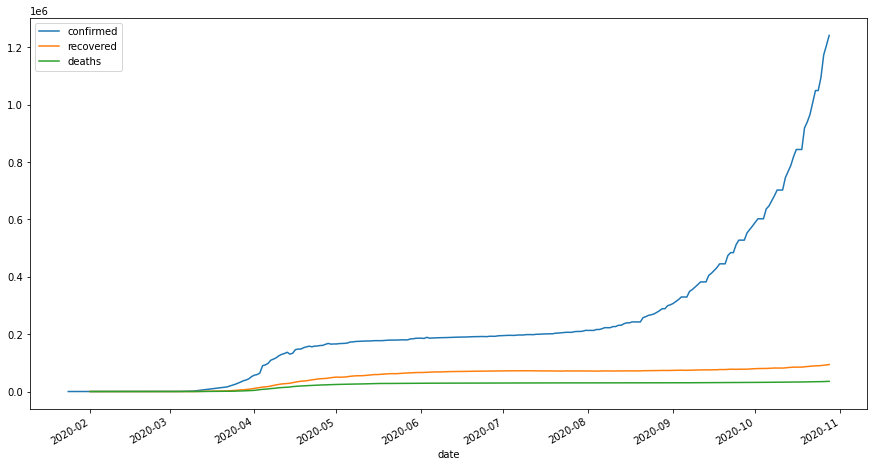

In [18]:
plt.rcParams['figure.figsize'] = [15, 8]
ax = plt.gca()
df_cp = df_by_country_province.get_group(country_province_filter)
df_cp.plot(x='date', y=indicators, ax=ax);

### Plot the 'confirmed' indicator for multiple countries

In [19]:
indicator = 'confirmed'
country_province_filter = [
    ('France' , 'Mainland'),
    ('Germany', '<all>'),
    ('Spain'  , '<all>'),
]

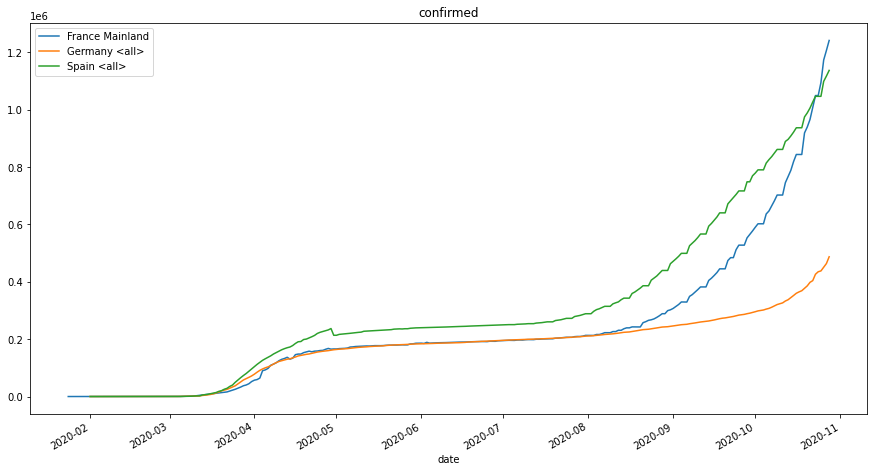

In [20]:
plt.rcParams['figure.figsize'] = [15, 8]
ax = plt.gca()
ax.set_title(indicator)
for cp in country_province_filter:
    label = f'{cp[0]} {cp[1]}'
    df_cp = df_by_country_province.get_group(cp)
    df_cp.plot(x='date', y=indicator, ax=ax, label=label);

## Display a dash/plotly Dashboard

In [21]:
from jupyter_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [22]:
# ENABLE THIS WHEN RUNNING IN JupyterHub or Binder
#JupyterDash.infer_jupyter_proxy_config()

In [23]:
# helper function
def to_options(values, unique=True, sort=True):
    """ helper dropdown options builder """
    if unique: values = values.unique()
    if sort  : values = sorted(values)        
    return [{'label': i, 'value': i} for i in values]

In [27]:
# Build the app
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash('Covid 19 Stats', external_stylesheets=external_stylesheets)
server = app.server

app.layout = html.Div([
    html.Div([
        html.Div([
            '''Choose a country:''',
            dcc.Dropdown('country', to_options(df_all.country)),
        ], style={'width': '49%', 'display': 'inline-block'}),
        html.Div([
            '''Choose a province:''',
            dcc.Dropdown('province', disabled=True),
        ], style={'width': '49%', 'float': 'right', 'display': 'inline-block'}),
    ], style={
        'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
        'padding': '10px 5px'}),
    html.Div([
        dcc.Graph('country-chart')
    ], style={'width': '98%', 'display': 'inline-block', 'padding': '0 20'}),
])

@app.callback([
    Output('province', 'disabled'),
    Output('province', 'options'),
], Input('country', 'value'))
def update_province(country):
    if country != '':
        return False, to_options(df_all.province[df_all['country'] == country])
    else:
        return True, None
        
@app.callback(Output('country-chart', 'figure'), [Input('country', 'value'), Input('province', 'value')])
def update_graph(country, province):
    df = df_all[ (df_all['country'] == country) & (df_all['province'] == province) ]
    indicator = 'deaths'
    return {
        'data': [ {
            'x' : df['date'],
            'y' : df['confirmed'],
            'mode' : 'lines',
            'name' : 'confirmed'
        }, {
            'x' : df['date'],
            'y' : df['deaths'],
            'mode' : 'lines',
            'name' : 'deaths'
        }],
        'layout': {
            'height': 500,
            'margin': {'l': 30, 'b': 30, 'r': 10, 't': 10},
            'annotations': [{
                'x': 0, 'y': 0.85, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(255, 255, 255, 0.5)',
                'text': f'{country} ({province}) {indicator}'
            }],
            'yaxis': {'type': 'linear' },
            'xaxis': {'showgrid': False}
        }
    }

Finally run the Dash app!

Remark: in the html static preview, the following cell remains empty, as its content requires the dash server to run 

In [28]:
# run the app 
#app.run_server(mode="jupyterlab")
app.run_server(mode="inline")